In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
detrend.py
----------

'''
from itertools import combinations_with_replacement as multichoose
from sklearn.decomposition import PCA
from scipy.misc import comb as nchoosek
import numpy as np


def PLDBasis(fpix, time=None, breakpoints=None, pld_order=1, cross_terms=True,
             max_components=300):
    '''
    Returns the basis vectors ``X`` we're going to use for the PLD model.
    ``X`` has shape (``npts``, ``n_components``). The first column ([:,0])
    is a vector of ones. The following columns are the principal components,
    in decreasing order of explained variance.

    '''

    # Our basis vector matrix: one set of basis vectors per chunk
    X = None

    # Fractional pixel fluxes
    npts, npix = fpix.shape
    frac = fpix / np.sum(fpix, axis=1).reshape(-1, 1)

    # The number of signals (equation 6 in the paper)
    nsignals = int(
        np.sum([nchoosek(npix + k - 1, k) for k in range(1, pld_order + 1)]))

    # Add the breakpoints
    if breakpoints:
        assert time is not None, "Missing ``time`` array in ``PLDBasis()``."
        f = []
        m = 0
        for b in list(breakpoints):
            n = np.argmin(np.abs(time - b))
            f.append(frac[m:n])
            m = n
        f.append(frac[m:])
        frac = f
    else:
        frac = [frac]

    # Adjust the maximum number of PCA components; must be less than
    # the number of points in a chunk, otherwise they won't be
    # linearly independent! Must also, of course, be less than or
    # equal to the number of signals in the first place
    n_components = max_components
    for f in frac:
        n_components = min(n_components, f.shape[0], nsignals)

    # Setup the design matrix
    sz = n_components * len(frac)
    X = np.empty((0, sz), dtype=float)
    for i, f in enumerate(frac):

        # Get the PLD arrays
        if not cross_terms:
            x = np.hstack([f ** (n + 1) for n in range(pld_order)])
        else:
            x = np.empty(shape=(f.shape[0], 0), dtype='float64')
            for n in range(1, pld_order + 1):
                xn = np.product(list(multichoose(f.T, n)), axis=1).T
                x = np.hstack([x, xn])

        # Perform PCA on them
        pca = PCA(n_components=n_components - 1)
        xpca = pca.fit_transform(x)

        # Prepend a column vector of ones, since PCA transform removes
        # the property that the basis vectors all sum to one.
        x = np.hstack([np.ones(xpca.shape[0]).reshape(-1, 1), xpca])

        # or with linear polynomial
        # x = np.hstack([np.ones(xpca.shape[0]).reshape(-1, 1),
        #                np.linspace(0, 1, xpca.shape[0]).reshape(-1, 1), xpca])

        # Pad with zeros on the left and right so that the chunks are
        # all independent of each other
        lzeros = np.zeros((x.shape[0], i * x.shape[1]))
        rzeros = np.zeros((x.shape[0], sz - (i + 1) * x.shape[1]))
        chunk = np.hstack((lzeros, x, rzeros))
        X = np.vstack((X, chunk))

    return X#, n_components

def PLDModel(C, X):
    '''
    Returns the PLD model given coefficients ``C`` and basis vectors ``X``.

    '''

    # It's really this simple!
    M = np.dot(C, X.T)

    return M


def PLDCoeffs(X, Y, time, errors):
    '''
    Computes the PLD coefficients ``C`` given the basis vectors ``X``, the
    data you wish to fit ``Y`` (typically the SAP flux), the time vector ``time``
    and the array of errors ``errors``.

    '''

    Kinv = np.diag(1. / errors ** 2)
    A = np.dot(np.dot(X.T, Kinv), X)
    B = np.dot(np.dot(X.T, Kinv), Y)
    C = np.linalg.solve(A, B)

    return C

In [34]:
from glob import glob

#paths = sorted(glob('r61066752/ch?/bcd/SPITZER*sub2d.fits')) # apparent spot occultation
#paths = sorted(glob('r62448128/ch?/bcd/SPITZER*sub2d.fits'))
#paths = sorted(glob('r62448896/ch?/bcd/SPITZER*sub2d.fits'))
#paths = sorted(glob('r62444544/ch?/bcd/SPITZER*sub2d.fits'))
paths = sorted(glob('r64615424/ch?/bcd/SPITZER*sub2d.fits'))

shape = fits.getdata(paths[0]).shape

In [35]:
n_crop = 18
images = np.zeros((len(paths), shape[0]-n_crop, shape[1]-n_crop))
times = np.zeros(len(paths))
for i, path in enumerate(paths):
    images[i, ...] = fits.getdata(path)[n_crop//2:-n_crop//2, n_crop//2:-n_crop//2]
    images[i, ...][np.isnan(images[i, ...])] = 0
    times[i] = fits.getheader(path)['BMJD_OBS']

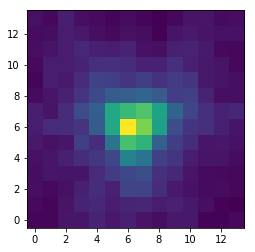

In [36]:
plt.imshow(np.log(np.sum(images, axis=0)), origin='lower')

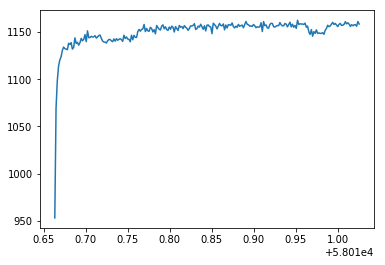

In [37]:
aperture_sum = np.sum(images, axis=(1, 2))

plt.plot(times, aperture_sum)

In [38]:
pixel_fluxes_0 = images.reshape((images.shape[0], 
                                 images.shape[1] ** 2))
pixel_errors_0 = np.sqrt(pixel_fluxes_0)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


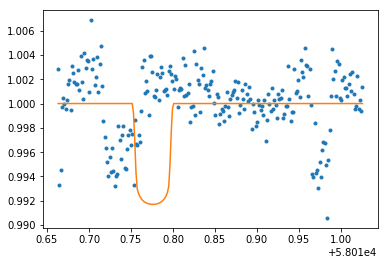

In [49]:
import sys
sys.path.insert(0, '../')
from toolkit import transit_model, trappist1
g = trappist1('g')


from astropy.time import Time
times_bjd = Time(times, format='mjd').jd
oot = transit_model(times_bjd, g) == 1
pld_order = 2


# for max_components in np.arange(5, 20):

#     basis0 = PLDBasis(pixel_fluxes_0, time=times, pld_order=pld_order,
#                       max_components=max_components)

#     total_fluxes0 = np.nansum(pixel_fluxes_0, axis=1)
#     total_errors0 = np.sqrt(np.nansum(pixel_fluxes_0, axis=1))
#     coeffs0 = PLDCoeffs(basis0, total_fluxes0, None, total_errors0)

#     model0 = PLDModel(coeffs0, basis0)

#     pld_light_curve = total_fluxes0 / model0

#     plt.plot(max_components, np.std(pld_light_curve[oot]), '.')
    
# plt.show()

max_components = 8

basis0 = PLDBasis(pixel_fluxes_0, time=times, pld_order=pld_order,
                  max_components=max_components)

total_fluxes0 = np.nansum(pixel_fluxes_0, axis=1)
total_errors0 = np.sqrt(np.nansum(pixel_fluxes_0, axis=1))
coeffs0 = PLDCoeffs(basis0, total_fluxes0, None, total_errors0)

model0 = PLDModel(coeffs0, basis0)

pld_light_curve = total_fluxes0 / model0


p = np.polyfit(times[oot], pld_light_curve[oot], 2)
polynomial = np.polyval(p, times)
plt.plot(times, pld_light_curve - polynomial + 1, '.')
plt.plot(times, transit_model(times_bjd, g))

np.savetxt('pld_{0}.txt'.format(int(times_bjd.min())), 
           np.vstack([times_bjd, pld_light_curve - polynomial + 1]).T)

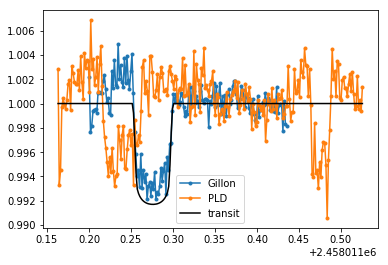

In [84]:
g_bjd, g_flux, _ = np.loadtxt('../reduced_lcs/lightcurve_0.txt', unpack=True)

pld_bjd, pld_flux = np.loadtxt('pld_2458011.txt', unpack=True)

plt.plot(g_bjd, g_flux, '.-', label='Gillon')
plt.plot(pld_bjd, pld_flux, '.-', label='PLD')
plt.plot(pld_bjd, transit_model(pld_bjd, g), 'k-', label='transit')
plt.legend()


(2457665.2010466796, 2457665.4197278796)

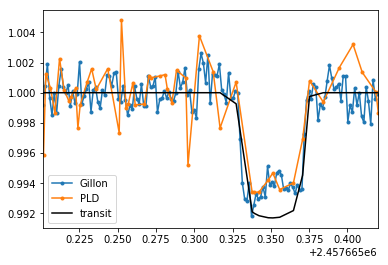

In [83]:
g_bjd, g_flux, _ = np.loadtxt('../reduced_lcs/lightcurve_1.txt', unpack=True)

pld_bjd, pld_flux = np.loadtxt('pld_2457664.txt', unpack=True)

plt.plot(g_bjd, g_flux, '.-', label='Gillon')
plt.plot(pld_bjd, pld_flux, '.-', label='PLD')

plt.plot(pld_bjd, transit_model(pld_bjd, g), 'k-', label='transit')
plt.legend()
plt.xlim([g_bjd.min(), g_bjd.max()])

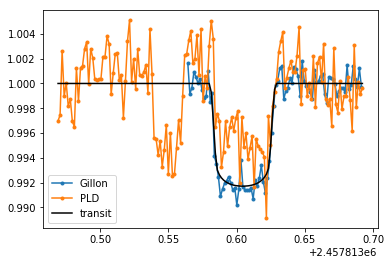

In [79]:
g_bjd, g_flux, _ = np.loadtxt('../reduced_lcs/lightcurve_2.txt', unpack=True)

pld_bjd, pld_flux = np.loadtxt('pld_2457813.txt', unpack=True)

plt.plot(g_bjd, g_flux, '.-', label='Gillon')
plt.plot(pld_bjd, pld_flux, '.-', label='PLD')
plt.plot(pld_bjd, transit_model(pld_bjd, g), 'k-', label='transit')
plt.legend()

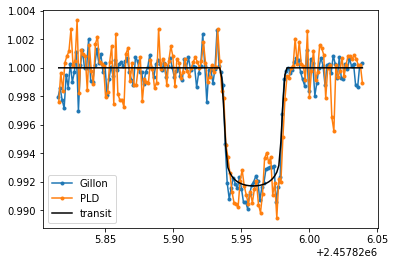

In [85]:
g_bjd, g_flux, _ = np.loadtxt('../reduced_lcs/lightcurve_3.txt', unpack=True)

pld_bjd, pld_flux = np.loadtxt('pld_2457825.txt', unpack=True)

plt.plot(g_bjd, g_flux, '.-', label='Gillon')
plt.plot(pld_bjd, pld_flux, '.-', label='PLD')
plt.plot(pld_bjd, transit_model(pld_bjd, g), 'k-', label='transit')
plt.legend()
plt.savefig('pld.png', bbox_inches='tight', dpi=200)

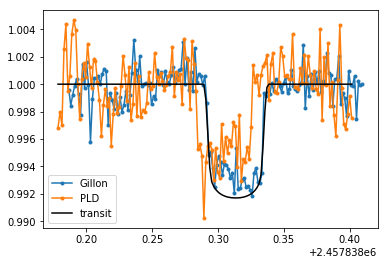

In [82]:
g_bjd, g_flux, _ = np.loadtxt('../reduced_lcs/lightcurve_4.txt', unpack=True)

pld_bjd, pld_flux = np.loadtxt('pld_2457838.txt', unpack=True)

plt.plot(g_bjd, g_flux, '.-', label='Gillon')
plt.plot(pld_bjd, pld_flux, '.-', label='PLD')
plt.plot(pld_bjd, transit_model(pld_bjd, g), 'k-', label='transit')
plt.legend()